# Sentiment Analysis

In [1]:
#import all the python libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

In [2]:
from matplotlib import style,rcParams
style.use('seaborn-white')
rcParams['figure.figsize'] = 10,5
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix

C:\Users\chenn\AppData\Local\Temp\ipykernel_14408\1683536954.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-white')


In [3]:
df_train = pd.read_csv("train.txt",delimiter=';',names=['text','label'])
df_val = pd.read_csv("val.txt",delimiter=';',names=['text','label'])

In [4]:
df = pd.concat([df_train,df_val])

In [5]:
df.shape

(18000, 2)

In [6]:
df.reset_index(inplace=True,drop=True)
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [7]:
df.info() # to get the Structure from dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    18000 non-null  object
 1   label   18000 non-null  object
dtypes: object(2)
memory usage: 281.4+ KB


In [8]:
# to get the statistical data
df.describe()

,text,label
count,18000,18000
unique,17962,6
top,i resorted to yesterday the post peak day of i...,joy
freq,2,6066


In [9]:
print(df.isnull().sum())

text     0
label    0
dtype: int64


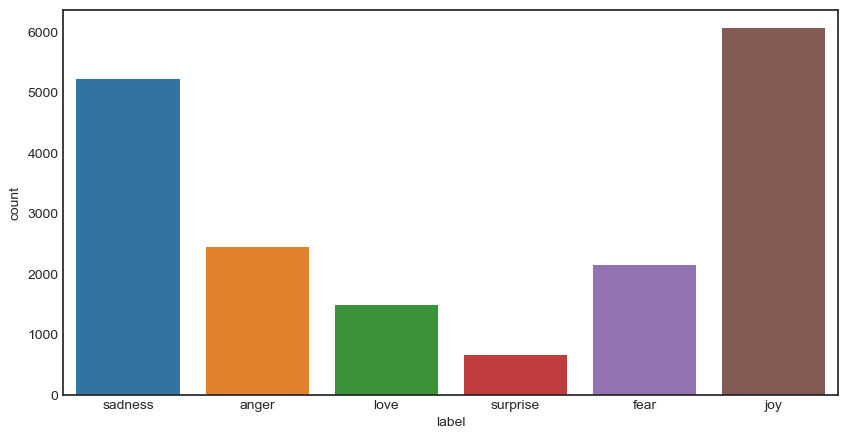

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the 'label' column
sns.countplot(data=df, x='label') 
plt.show() 

As we can see that, we have 6 labels or targets in the dataset. We can make a multi-class classifier for Sentiment Analysis. But, for the sake of the simplicity, we will merge these labels into two classes, i.e. Positive or Negative sentiment.

* Positive Sentiment - "joy", "love", "surprise"

* Negative Sentiment - "anger", "sadness", "fear"

Now, we will create a custom encoder to convert categorical target labels to numerical form, i.e. (0 and 1)

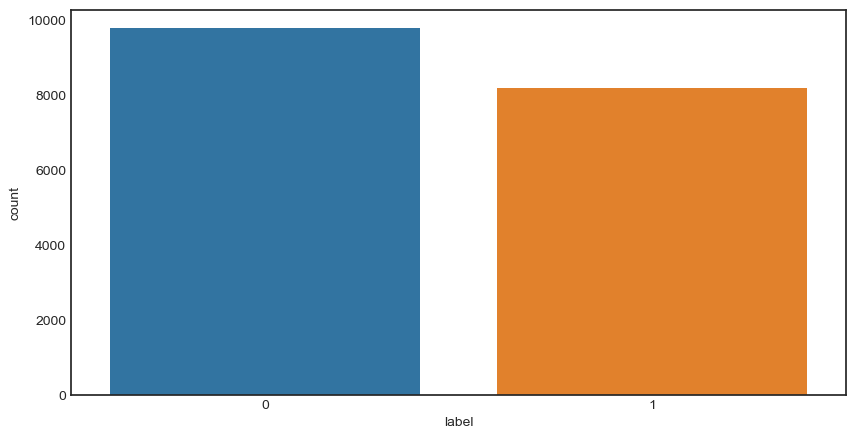

In [11]:
def custom_encoder(df):
    df['label'].replace(to_replace=["surprise", "love", "joy"], value=1, inplace=True)
    df['label'].replace(to_replace=["fear", "anger", "sadness"], value=0, inplace=True)

custom_encoder(df)  # Apply the custom_encoder function to the entire DataFrame
sns.countplot(data=df, x='label')  
plt.show()  

Now, we can see that our target have changed to 0 and 1, and the data is more or less in a balanced state.

In [12]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,1
4,i am feeling grouchy,0


Now, we will perform some pre-processing on the data before converting it into vectors and passing it to the machine learning model.

In [13]:
#object of WordNetLemmatizer
lm = WordNetLemmatizer()

#We will create a function for pre-processing of data

* First, we will iterate through each record and using regualr expression, we will get rid of any characters apart from    alphabets.

* Then, we will convert the string to lowercase as, the word "Good" is different from the word "good". This will cause an issue, when we will create vectors of these words, as two different vectors will be created for the same word which we don't want to.

* Then we will check for stopwords in the data and get rid of them. Stopwords are commonly used words in a sentence such as "the","an","to" etc. which do not add much value.

* Then, we will perform lemmatization on each word,i.e. change the different forms of word into a single item called as lemma. A lemma is a base form of a word. For example, run, running and runs are all forms of same lexeme where run is the lemma. Hence, we are converting all occurrences of same lexeme to it's respective lemma.

* And, then return a corpus of processed data

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [WinError 10061]
[nltk_data]     No connection could be made because the target machine
[nltk_data]     actively refused it>


False

In [15]:
def text_transformation(df):
    corpus = []
    for item in df:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [16]:
def custom_encoder(df):
    df.replace(to_replace ="surprise", value =1, inplace=True)
    df.replace(to_replace ="love", value =1, inplace=True)
    df.replace(to_replace ="joy", value =1, inplace=True)
    df.replace(to_replace ="fear", value =0, inplace=True)
    df.replace(to_replace ="anger", value =0, inplace=True)
    df.replace(to_replace ="sadness", value =0, inplace=True)

In [17]:
custom_encoder(df['label'])

In [18]:
#object of WordNetLemmatizer
lm = WordNetLemmatizer()

In [19]:
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [20]:
corpus = text_transformation(df['text'])

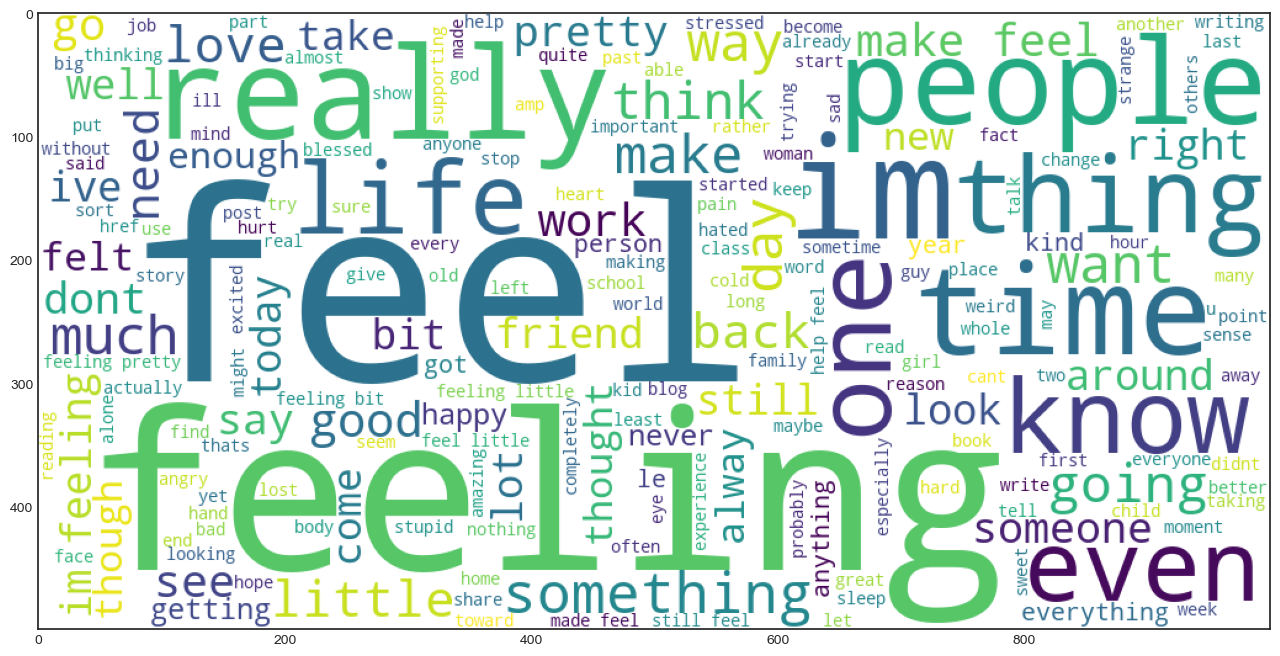

In [21]:
rcParams['figure.figsize'] = 20,8
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)

wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

In [23]:
cv = CountVectorizer(ngram_range=(1,2))
traindata = cv.fit_transform(corpus)

In [24]:
X = traindata
y = df.label

In [25]:
parameters = {'max_features': ('auto','sqrt'),
             'n_estimators': [500, 1000],
             'max_depth': [10, None],
             'min_samples_split': [5],
             'min_samples_leaf': [1],
             'bootstrap': [True]}

In [26]:
grid_search = GridSearchCV(RandomForestClassifier(),parameters,cv=5,return_train_score=True,n_jobs=-1)
grid_search.fit(X,y)
grid_search.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1000}

#### Displays models and their respective parameters, mean test score and rank.

In [27]:
for i in range(6):
    print('Parameters: ',grid_search.cv_results_['params'][i])
    print('Mean Test Score: ',grid_search.cv_results_['mean_test_score'][i])
    print('Rank: ',grid_search.cv_results_['rank_test_score'][i])

Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Mean Test Score:  nan
Rank:  5
Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
Mean Test Score:  nan
Rank:  5
Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Mean Test Score:  0.5455555555555556
Rank:  3
Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
Mean Test Score:  0.5449444444444443
Rank:  4
Parameters:  {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Mean Test Score:  nan
Rank:  5
Parameters:  {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'm

#### Now, we will choose the best parameters obtained from GridSearchCV and create a final random forest classifier model

In [28]:
rfc = RandomForestClassifier(max_features=grid_search.best_params_['max_features'],
                                      max_depth=grid_search.best_params_['max_depth'],
                                      n_estimators=grid_search.best_params_['n_estimators'],
                                      min_samples_split=grid_search.best_params_['min_samples_split'],
                                      min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                                      bootstrap=grid_search.best_params_['bootstrap'])

#### Now, we will train our new model.

In [29]:
rfc.fit(X,y)

RandomForestClassifier(min_samples_split=5, n_estimators=1000)

### Test Data Transformation

In [30]:
test_df = pd.read_csv('test.txt',delimiter=';',names=['text','label'])

In [31]:
X_test,y_test = test_df.text,test_df.label
#encode the labels into two classes , 0 and 1
test_df = custom_encoder(y_test)
#pre-processing of text
test_corpus = text_transformation(X_test)
#convert text data into vectors
testdata = cv.transform(test_corpus)
#predict the target
predictions = rfc.predict(testdata)

### Model Evaluation Metrics

Accuracy_score:  0.96
Precision_score:  0.9605263157894737
Recall_score:  0.9521739130434783
-------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1080
           1       0.96      0.95      0.96       920

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



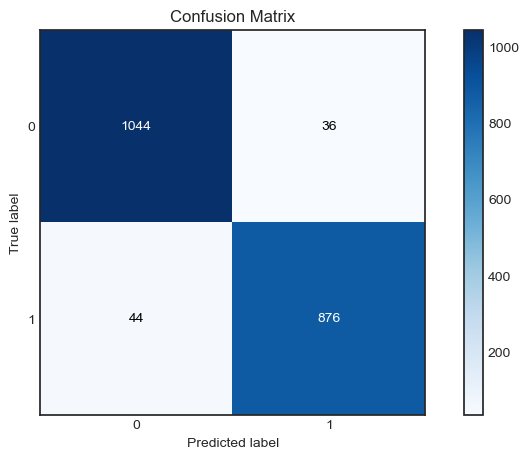

In [32]:
rcParams['figure.figsize'] = 10,5
plot_confusion_matrix(y_test,predictions)
acc_score = accuracy_score(y_test,predictions)
pre_score = precision_score(y_test,predictions)
rec_score = recall_score(y_test,predictions)
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print('-------------------------------------------------------------------')
cr = classification_report(y_test,predictions)
print(cr)

In [33]:
predictions_probability = rfc.predict_proba(testdata)

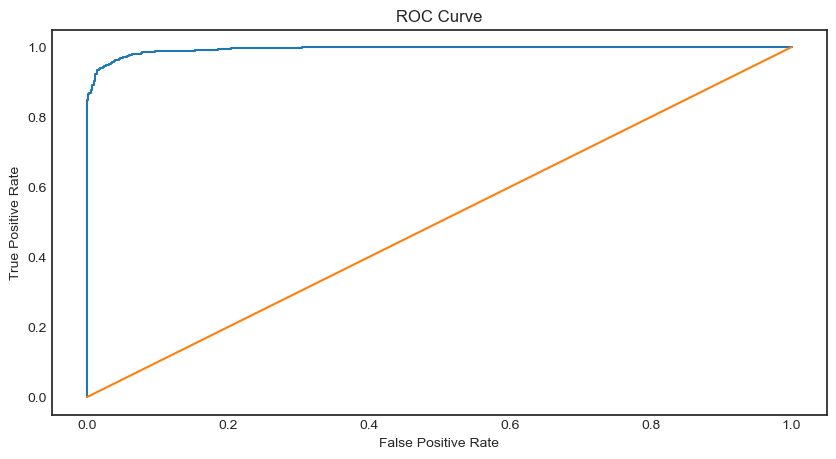

In [34]:
fpr,tpr,thresholds = roc_curve(y_test,predictions_probability[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Predict for Custom Input

In [35]:
def expression_check(prediction_input):
    if prediction_input == 0:
        print("Input statement has Negative Sentiment.")
    elif prediction_input == 1:
        print("Input statement has Positive Sentiment.")
    else:
        print("Invalid Statement.")

In [36]:
def sentiment_predictor(input):
    input = text_transformation(input)
    transformed_input = cv.transform(input)
    prediction = rfc.predict(transformed_input)
    expression_check(prediction)

In [37]:
input1 = ["Sometimes I just want to punch someone in the face."]
input2 = ["I bought a new phone and it's so good."]
sentiment_predictor(input1)
sentiment_predictor(input2)

Input statement has Negative Sentiment.
Input statement has Positive Sentiment.


### *........THE END.........*